In [1]:
## This code read SVHN original pictures, and extract features from provided boxes. 
##It also extract non-digit patches, and predict if its actually non-digit or not.
import scipy.io as sio
import numpy as np
import itertools
import cv2
import pickle
import sys
from feature_extractor import ThreeChannelsFeatureExtractor
from processor_stack import ProcessorStack
from processor import (GrayScaleProcessor, BlurProcessor, SobelProcessor, 
                       ThresholdProcessor, MorphologyProcessor, HistogramEqualizationProcessor,
                      CannyProcessor, ScaleProcessor, HoughLinesProcessor,
                      SaveImageProcessor, InvertProcessor, RetrieveImageProcessor)
from segment_processor import (HierarchyContourSegmenter, LargeSegmentFilter, 
                               SmallSegmentFilter, LargeAreaSegmentFilter, ContainedSegmentFilter, UniqueSegmentFilter,
                              RatioSegmentFilter)

from segment_classifier import NonDigitSegmentClassifier
from feature_extractor import (SimpleFeatureExtractor, ThreeChannelsFeatureExtractor)
adaptiveBlockSizes = [9, 17, 31]
erodes = [(0, 0), (3, 3), (3, 3), (5, 5), (7, 7)]
dilates = [(0, 0),(3, 3), (7, 3), (5, 3), (7, 3)]

imDir = 'J:/SVHN/test/'

#Box is represented by x, y, w, h. x, y is top left.
def readDigitStruct (digitStruct):
    #Return name, and an array of boxes
    name = digitStruct[0][0]
    boxes = digitStruct[1][0]
    segments = []
    segment_types = []
    for i in range(len(boxes)):
        box = boxes[i]
        x = box[1][0][0]
        y = box[2][0][0]
        h = box[0][0][0]
        w = box[3][0][0]
        segment = (x, y, w, h)
        segment_type = box[4][0][0]
        segments.append(segment)
        segment_types.append(segment_type)
    segment_types = np.array(segment_types).astype(int)
    segment_types[segment_types == 10] = 0
    return (name, np.array(segments).astype(int), segment_types)

def propose_segments(image):
    segments = np.empty( shape=(0, 0) )
    for adaptiveBlockSize, ((erode_x, erode_y), (dilate_x, dilate_y))  in itertools.product(adaptiveBlockSizes, zip(erodes, dilates)):
        digitDetectorStack = [#ScaleProcessor(maxHeight=800, maxWidth=800),
             SaveImageProcessor(),
             GrayScaleProcessor(),
             BlurProcessor(blur_x=5, blur_y=5),
             HistogramEqualizationProcessor(HistogramEqualizationProcessor.CLAHE),
             ThresholdProcessor(ThresholdProcessor.ADAPTIVE, adaptiveBlockSize=adaptiveBlockSize), # 31 for normal. Change this to catch digits!
             MorphologyProcessor(shape=cv2.MORPH_RECT, ksize=(erode_x, erode_y), op = MorphologyProcessor.ERODE), #Change this
             MorphologyProcessor(shape=cv2.MORPH_RECT, ksize=(dilate_x, dilate_y), op = MorphologyProcessor.DILATE),
             HierarchyContourSegmenter(),
             RetrieveImageProcessor(),
             LargeSegmentFilter(min_width=4, min_height=13),
             SmallSegmentFilter(max_width=100, max_height=200),
             LargeAreaSegmentFilter(min_area = 120),
             RatioSegmentFilter(min_h_w_ratio = 1, max_h_w_ratio = 4.5)
             ] 
        digitDetector = ProcessorStack(digitDetectorStack)
        digitDetector.process(image)
        #digitDetector.display()
        output = digitDetector.get_output()
        if len(segments) == 0:
            segments = output['segments']
            image = output['originalImg']
        else:
            segments = np.concatenate((segments, output['segments']), axis = 0)
    
    segmentFilterStack = [UniqueSegmentFilter(threshold = 0.7),
                          ThreeChannelsFeatureExtractor(feature_size=32, extension = 1, 
                                                        method=ThreeChannelsFeatureExtractor.PAD_BACKGROUND ,display_features = False)
                         ]
    segmentFilter = ProcessorStack(segmentFilterStack)
    segmentFilter.process(image, segments = segments)
    return segmentFilter

def processImage (image, segments, segment_types):
    #featureExtractStack = [ThreeChannelsFeatureExtractor(feature_size=32, extension = 1, 
    #                                                method=ThreeChannelsFeatureExtractor.PAD_BACKGROUND ,display_features = True)]
    #featureExtractor = ProcessorStack(featureExtractStack)
    
    #featureExtractor.process(image, segments = segments, segment_types = segment_types)
    #cv2.namedWindow( "Original", cv2.WINDOW_AUTOSIZE );
    #cv2.imshow( "Original", image );    
    #featureExtractor.display()
    segmentProposer = propose_segments(image)
    non_digit_segments = segmentProposer.get_output()['segments']
    
    nonDigitClassifyStack = [NonDigitSegmentClassifier(loose_high_threshold = 0.8, loose_low_threshold = 0.15, occupy_threshold = 0.8),
                            ThreeChannelsFeatureExtractor(feature_size=32, extension = 1, 
                                                    method=ThreeChannelsFeatureExtractor.PAD_BACKGROUND ,display_features = True)]
    nonDigitClassifier = ProcessorStack(nonDigitClassifyStack)
    nonDigitClassifier.process(image, digit_segments = segments, 
                               digit_segment_types = segment_types, 
                               non_digit_segments = non_digit_segments)
    nonDigitClassifier.display()
    regions, labels = nonDigitClassifier.get_output()['regions'], nonDigitClassifier.get_output()['segment_types']
    return (regions, labels)
    

#with open(imDir +'boxes.pkl', 'rb') as input:
#    boxes = pickle.load(input)
#imDir = sys.argv[1]
print 'Generating data from: ', imDir

boxes = sio.loadmat(imDir + 'digitStruct_v7.mat')
boxes = boxes['digitStruct']

n = boxes.shape[1]
print "Total Images:", n
X_train = []
y_train = []
for i in range(n):
    imName, segments, segment_types = readDigitStruct(boxes[0, i])
    image = cv2.imread(imDir + imName)
    if image is not None:
        regions, labels = processImage (image, segments, segment_types)
        X_train.append(regions)
        y_train.append(labels)
        
    if ((i+1)%1000 == 0) or (i+1 == n):
        print i
        sys.stdout.flush()
        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_train = np.rollaxis(X_train, 3, 1)
        print X_train.shape
        
        np.savez(imDir + "total_" + str(i)+'.npz', X_train=X_train, y_train = y_train)
        X_train = []
        y_train = []


C:\Anaconda\lib\site-packages\theano\configdefaults.py:1439: UserWarning: Theano does not recognise this flag: blas.ldflags
  warnings.warn('Theano does not recognise this flag: {}'.format(key))
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/k/AppData/Local/Theano/compiledir_Windows-7-6.1.7600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/cuda_ndarray/cuda_ndarray.lib and object C:/Users/k/AppData/Local/Theano/compiledir_Windows-7-6.1.7600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/cuda_ndarray/cuda_ndarray.exp

Using gpu device 0: Quadro K1100M (CNMeM is disabled, CuDNN not available)
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/k/AppData/Local/Theano/compiledir_Windows-7-6.1.7600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpsliq9b/97496c4d3cf9a06dc4082cc141f918d2.lib and object C:/Users/k/AppData/Local/Theano/compiledir_Windows-7-6.1.7600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmps

Generating data from:  J:/SVHN/test/


IOError: [Errno 2] No such file or directory: 'J:/SVHN/test/digitStruct_v7.mat'

In [ ]:
##This code convert matlab file extra.mat into friendly format that can be used as training data in theano
import scipy.io as sio
import numpy as np
def adjust_dim_nfirst(a):
    return np.rollaxis(a, 3, 0)
def squeeze_target(y):
    return np.squeeze(y, 1)
def adjust_dim_channel_last(a):
    return np.rollaxis(a, 3, 1)
def load_svhn(filename):
    data = sio.loadmat(filename)
    X = data['X'] #4 dims: 32 rows, 32 columns, 3 channels, n images
    X = adjust_dim_nfirst(X)#4 dims: n images, 32 rows, 32 columns, 3 channels
    y = data['y']
    y = squeeze_target(y)
    y[y==10] = 0
    X = adjust_dim_channel_last(X) #Now n images, 1 (or 3) channel, 32 rows, 32 columns
    #y.fill(1)
    return X, y

X_extra, y_extra = load_svhn('J:/SVHN/extra/extra_32x32.mat')
np.savez('J:/SVHN/extra/' + "total_extra.npz", X_train=X_extra, y_train = y_extra)

In [ ]:
%matplotlib inline
#Plot some example!
import matplotlib.pyplot as plt
import matplotlib.cm as cm
filename = 'J:/SVHN/extra/total_extra10000.npz'
import numpy as np
import random

def plot_image(img):
    x = np.rollaxis(img, 0, 3)
    if (x.shape[2] == 1):
        x = np.squeeze(x, axis=(2,))
        plt.imshow(x, cmap = cm.Greys_r)
    else:
        plt.imshow(x)
    plt.show()

def plot_random_image(imgs, target=None, n=100):
    indices = random.sample(xrange(0, imgs.shape[0]),  n)
    for index in indices:
        plot_image(imgs[index, :, :, :])
        if target != None:
            print target[index]

with np.load(filename) as f:
    X_train = f['X_train']
    y_train = f['y_train']

plot_random_image(X_train, y_train)
print X_train.shape
print y_train.shape




Counting rows from  J:/SVHN/train/
Counting rows from  J:/SVHN/extra/
Counting rows from  J:/SVHN/test/
1670904
Importing data from  J:/SVHN/train/
Importing data from  J:/SVHN/extra/
Importing data from  J:/SVHN/test/
Import - OK
(1670904, 3, 32, 32) (1670904,)


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:146: DeprecationWarning: createCArray() is pending deprecation, use create_carray() instead. You may use the pt2to3 tool to update your source code.
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:147: DeprecationWarning: createCArray() is pending deprecation, use create_carray() instead. You may use the pt2to3 tool to update your source code.


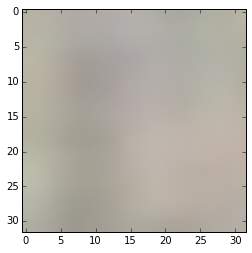

10


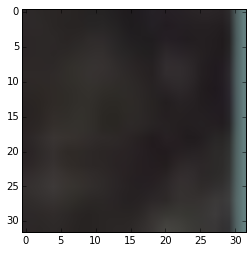

10


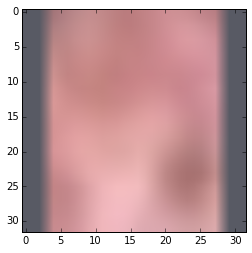

10


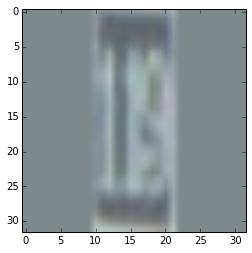

10


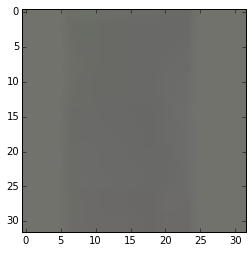

10


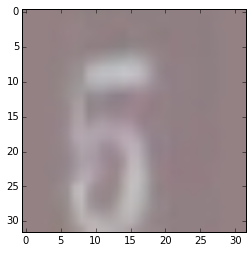

5


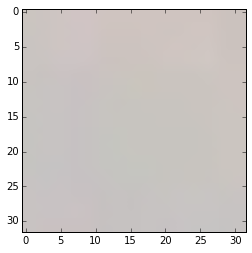

10


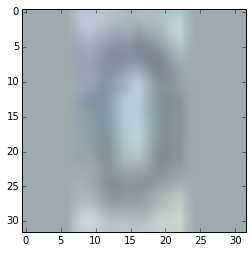

0


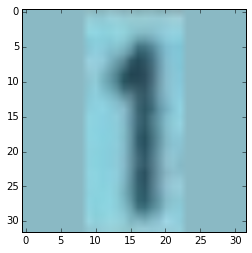

1


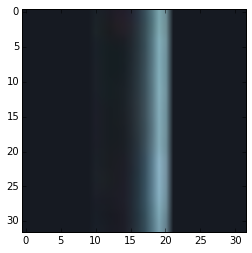

10
1503813 83545 83546
Shuffling...
The last n%10000 rows are shuffled and append to the output
Shuffling chunk  slice(0, 100000, None)
Shuffling chunk  slice(100000, 200000, None)
Shuffling chunk  slice(200000, 300000, None)
Shuffling chunk  slice(300000, 400000, None)
Shuffling chunk  slice(400000, 500000, None)
Shuffling chunk  slice(500000, 600000, None)
Shuffling chunk  slice(600000, 700000, None)
Shuffling chunk  slice(700000, 800000, None)
Shuffling chunk  slice(800000, 900000, None)
Shuffling chunk  slice(900000, 1000000, None)
Shuffling chunk  slice(1000000, 1100000, None)
Shuffling chunk  slice(1100000, 1200000, None)
Shuffling chunk  slice(1200000, 1300000, None)
Shuffling chunk  slice(1300000, 1400000, None)
Shuffling chunk  slice(1400000, 1500000, None)
Shuffling chunk  slice(1500000, 1600000, None)
slice(1600000, 1670904, None)


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:170: DeprecationWarning: createCArray() is pending deprecation, use create_carray() instead. You may use the pt2to3 tool to update your source code.


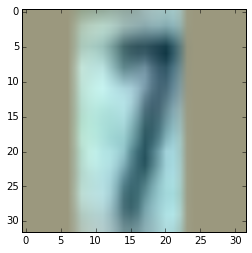

7
(1503813, 83545, 83546)
Copying array...
Copying array...


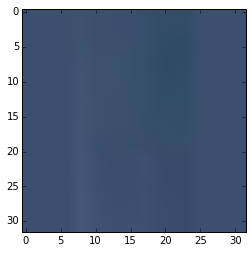

10
Copying array...
Copying array...
Copying array...
Copying array...
DONE!
Remember to use ptrepack to compress file
Run script 'ptrepack --chunkshape=auto --propindexes --complevel=1 --complib=blosc in.h5 out.h5'


In [1]:
##This code concatenate all available data into single hdf5 file
## All training matrix X must be in this format: n (images) x 3 (chanels) x 32 (rows) x 32 (columns)
%matplotlib inline
import scipy.io
from urllib import urlretrieve

import sys
import os
import time
import glob

import numpy as np
import tables as tb

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import math
import random 

H5_FILE = 'J:/SVHN/svhn_data.h5'
COMPRESSED_H5_FILE = 'J:/SVHN/compressed_svhn_data.h5'
TRAIN_DIR = 'J:/SVHN/train/'
EXTRA_DIR = 'J:/SVHN/extra/'
TEST_DIR = 'J:/SVHN/test/'
DIR_LIST = [TRAIN_DIR, EXTRA_DIR, TEST_DIR]
TRAIN_PERCENT = 0.9
VAL_PERCENT = 0.05
TEST_PERCENT = 0.05

def plot_image(img):
    x = np.rollaxis(img, 0, 3)
    if (x.shape[2] == 1):
        x = np.squeeze(x, axis=(2,))
        plt.imshow(x, cmap = cm.Greys_r)
    else:
        plt.imshow(x)
    plt.show()

def plot_random_image(imgs, target=None, n=10):
    indices = random.sample(xrange(0, imgs.shape[0]),  n)
    for index in indices:
        plot_image(imgs[index, :, :, :])
        if target != None:
            print target[index]




def rgb2gray(rgb):
    gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
    gray = gray.astype(np.float32)
    gray = np.expand_dims(gray, axis=3)
    return gray

def iterate_minibatches(inputs, batchsize):
    for start_idx in range(0, len(inputs), batchsize):
        excerpt = slice(start_idx, min(start_idx + batchsize, len(inputs)))
        yield inputs[excerpt]

def scale_data(X):
    return X / np.float32(256)

def h5_fast_bool_ix(h5_array, ix, read_chunksize=100000):
    '''Iterate over an h5 array chunkwise to select a random subset
    of the array. h5_array should be the array itself; `ix` should
    be a boolean index array with as many values as `h5_array` has
    rows; and you can optionally set the number of rows to read per
    chunk with read_chunksize (default is 100000). For some reason
    this is much faster than using ix to index the array directly.'''

    n_chunks = len(h5_array) / read_chunksize
    slices = [slice(i * read_chunksize, (i + 1) * read_chunksize)
              for i in range(n_chunks)]
    a_shape = list(h5_array.shape)
    print a_shape
    print ix.sum()
    a_shape[0] = ix.sum()
    a = np.empty(a_shape, dtype=float)
    a_start = 0
    for sl in slices:
        chunk = h5_array[sl][ix[sl]]
        a_end = a_start + chunk.shape[0]
        a[a_start:a_end] = chunk
        a_start = a_end

    return a

def shuffle_array(X, y, shuffled_X, shuffled_y, read_chunksize = 10000):
    print "Shuffling..."
    print "The last n%", read_chunksize, " rows are shuffled and append to the output"
    n_chunks = len(X) / read_chunksize
    slices = [slice(i * read_chunksize, (i + 1) * read_chunksize)
              for i in range(n_chunks)]
    chunk_idx = range(n_chunks)
    np.random.shuffle(chunk_idx)
    for i in range(n_chunks):
        sl = slices[i]
        random_sl = slices[chunk_idx[i]]
        print 'Shuffling chunk ', sl
        #if (sl.stop-sl.start) != (random_sl.stop-random_sl.start):
        #    continue;
        chunkX = X[sl]
        chunkY = y[sl]
        random_idx = range(len(chunkX))
        np.random.shuffle(random_idx)
        chunkX = chunkX[random_idx]
        chunkY = chunkY[random_idx]
        shuffled_X[random_sl] = chunkX
        shuffled_y[random_sl] = chunkY
    
    last_sl = slice(n_chunks*read_chunksize, len(X))
    print last_sl
    chunkX = X[last_sl]
    chunkY = y[last_sl]
    random_idx = range(len(chunkX))
    np.random.shuffle(random_idx)
    shuffled_X[last_sl] = chunkX[random_idx]
    shuffled_y[last_sl] = chunkY[random_idx]
    
def copy_array(A, B, from_idx, to_idx, read_chunksize = 100000):
    n_chunks = int(math.ceil((to_idx-from_idx) / float(read_chunksize)))
    slices = [slice(from_idx + i * read_chunksize, from_idx + min((i + 1) * read_chunksize, to_idx-from_idx))
              for i in range(n_chunks)]
    b_start = 0
    print 'Copying array...'
    for sl in slices:
        chunk = A[sl]
        b_end = b_start + len(chunk)
        B[slice(b_start,b_end)] = chunk
        b_start = b_end
    
def count_rows( DIR_LIST ):
    n = 0
    for DIR in DIR_LIST:
        print 'Counting rows from ', DIR
        for dataset_file in glob.glob(DIR + '*.npz'):
            with np.load(dataset_file) as f:
                X_train = f['X_train']
                y_train = f['y_train']
            n = n + len(X_train)
    return n

def import_data( DIR_LIST, hdf5_file, n_imgs):
    root = hdf5_file.root
    X = hdf5_file.createCArray(root,'X',tb.Float32Atom(),shape=(n_imgs, 3, 32, 32))
    y = hdf5_file.createCArray(root,'y',tb.Int8Atom(),shape=(n_imgs, ))

    X_start = 0
    for DIR in DIR_LIST:
        print 'Importing data from ', DIR
        for dataset_file in glob.glob(DIR + '*.npz'):
            with np.load(dataset_file) as f:
                X_train = f['X_train']
                y_train = f['y_train']

            X_end = X_start + len(X_train)
            X[X_start:X_end] = X_train
            y[X_start:X_end] = y_train
            X_start = X_end
    return X, y

def preprocess_data( X, y ):
    for batch in iterate_minibatches(X, 500):
        batch = scale_data(batch)
    return X, y

def create_or_read(hdf5_file, node_name, atom, shape):
    try:
        node = hdf5_file.createCArray('/',node_name,atom,shape)
    except:
        node = hdf5_file.getNode('/'+node_name)
    return node
def split_data( X, y, hdf5_file, TRAIN_PERCENT, VAL_PERCENT, TEST_PERCENT ):
    root = hdf5_file.root
    #Shuffle the data to create train/val/test set
    assert(TRAIN_PERCENT + VAL_PERCENT + TEST_PERCENT == 1)
    n = len(X)
    n_train = int(n*TRAIN_PERCENT)
    n_val = int(n*VAL_PERCENT)
    n_test = n - n_train - n_val
    
    print n_train, n_val, n_test
    shuffled_X = create_or_read(hdf5_file,'shuffled_X',tb.Float32Atom(),shape=(n, 3, 32, 32))
    shuffled_y = create_or_read(hdf5_file,'shuffled_y',tb.Int8Atom(),shape=(n, ))
    shuffle_array(X, y, shuffled_X, shuffled_y, read_chunksize = 100000)
    plot_random_image(shuffled_X, shuffled_y, n=1)
    X_train = create_or_read(hdf5_file,'X_train',tb.Float32Atom(),shape=(n_train, 3, 32, 32))
    y_train = create_or_read(hdf5_file,'y_train',tb.Int8Atom(),shape=(n_train, ))
    X_val = create_or_read(hdf5_file,'X_val',tb.Float32Atom(),shape=(n_val, 3, 32, 32))
    y_val = create_or_read(hdf5_file,'y_val',tb.Int8Atom(),shape=(n_val, ))
    X_test = create_or_read(hdf5_file,'X_test',tb.Float32Atom(),shape=(n_test, 3, 32, 32))
    y_test = create_or_read(hdf5_file,'y_test',tb.Int8Atom(),shape=(n_test, ))
    print (len(X_train), len(X_val), len(X_test))
    copy_array(shuffled_X, X_test, n_train+n_val, n)
    copy_array(shuffled_y, y_test, n_train+n_val, n)
    plot_random_image(X_test, y_test, n=1)
    
    
    copy_array(shuffled_X, X_train, 0, n_train)
    copy_array(shuffled_y, y_train, 0, n_train)

    copy_array(shuffled_X, X_val, n_train, n_train + n_val)
    copy_array(shuffled_y, y_val, n_train, n_train + n_val)
    
    
    hdf5_file.flush()
    return X_train, y_train, X_val, y_val, X_test, y_test

hdf5_file  = tb.open_file(H5_FILE, mode = "a", title = "Whole Dataset")
#X = hdf5_file.root.X
#y = hdf5_file.root.y
n_imgs = count_rows( DIR_LIST )
print n_imgs
X, y = import_data( DIR_LIST, hdf5_file, n_imgs)
print 'Import - OK'
print X.shape, y.shape
X, y = preprocess_data( X, y )
plot_random_image(X, y , n=10)
hdf5_file.flush()
X_train, y_train, X_val, y_val, X_test, y_test = split_data( X, y, hdf5_file, TRAIN_PERCENT, VAL_PERCENT, TEST_PERCENT )

hdf5_file.remove_node('/X')
hdf5_file.remove_node('/y')
hdf5_file.remove_node('/shuffled_X')
hdf5_file.remove_node('/shuffled_y')

print "DONE!"
print "Remember to use ptrepack to compress file"
print "Run script 'ptrepack --chunkshape=auto --propindexes --complevel=1 --complib=blosc in.h5 out.h5'"

hdf5_file.close()

In [ ]:
X_test = hdf5

In [ ]:
import tables as tb
H5_FILE = 'J:/SVHN/svhn_data.h5'

hdf5_file  = tb.open_file(H5_FILE, mode = "a", title = "Whole Dataset")
hdf5_file.remove_node('/X_train')
hdf5_file.remove_node('/y_train')
hdf5_file.remove_node('/X_val')
hdf5_file.remove_node('/y_val')
hdf5_file.remove_node('/X_test')
hdf5_file.remove_node('/y_test')



In [ ]:
X_idx = range(10)
np.random.shuffle(X_idx)
print X_idx
X_train_idx = np.zeros(10, dtype=bool)
print X_train_idx
X_train_idx[X_idx[0:8]] = True
print X_train_idx

In [ ]:
import tables as tb
H5_FILE = 'J:/SVHN/svhn_data.h5'

hdf5_file  = tb.open_file(H5_FILE, mode = "a", title = "Whole Dataset")
#hdf5_compress_file  = tb.open_file('J:/SVHN/compressed_svhn_data.h5', mode = "a", title = "Whole Dataset")

X_train= hdf5_file.get_node('/X_train')
y_train= hdf5_file.get_node('/y_train')
X_val= hdf5_file.get_node('/X_val')
y_val = hdf5_file.get_node('/y_val')
X_test= hdf5_file.get_node('/X_test')
y_test = hdf5_file.get_node('/y_test')
shuffled_X = hdf5_file.get_node('/shuffled_X')
shuffled_y = hdf5_file.get_node('/shuffled_y')

        
#copy_array(shuffled_X, X_val, 10000, 20000)

def plot_image(img):
    x = np.rollaxis(img, 0, 3)
    if (x.shape[2] == 1):
        x = np.squeeze(x, axis=(2,))
        plt.imshow(x, cmap = cm.Greys_r)
    else:
        plt.imshow(x)
    plt.show()

def plot_random_image(imgs, target=None, n=10):
    indices = random.sample(xrange(0, imgs.shape[0]),  n)
    for index in indices:
        plot_image(imgs[index, :, :, :])
        if target != None:
            print target[index]

plot_random_image(X_train, y_train, n= 100)
hdf5_file.close()

In [ ]:
math.ceil((20000-10000)/float(100000))

In [ ]:
a = [1,2,3,4]
a.append(1)
print a

In [ ]:
hdf5_compress_file.close()

In [ ]:
import tables as tb
H5_FILE = 'J:/SVHN/svhn_data.h5'

hdf5_file  = tb.open_file(H5_FILE, mode = "a", title = "Whole Dataset")
hdf5_file

In [ ]:
hdf5_file.flush()

In [ ]:
hdf5_file.close()

In [ ]:
import numpy
a = numpy.array([[1,2,3], [3,2,1]])
b = numpy.array([[1,3,2], [1,3,2]])
l = [a, b]
c = numpy.asarray(l)
d = numpy.concatenate(l)
print c
print d

In [ ]:
import scipy.io as sio
import numpy as np
import itertools
import cv2
import pickle
from feature_extractor import ThreeChannelsFeatureExtractor
from processor_stack import ProcessorStack
from processor import (GrayScaleProcessor, BlurProcessor, SobelProcessor, 
                       ThresholdProcessor, MorphologyProcessor, HistogramEqualizationProcessor,
                      CannyProcessor, ScaleProcessor, HoughLinesProcessor,
                      SaveImageProcessor, InvertProcessor, RetrieveImageProcessor)
from segment_processor import (HierarchyContourSegmenter, LargeSegmentFilter, 
                               SmallSegmentFilter, LargeAreaSegmentFilter, ContainedSegmentFilter, UniqueSegmentFilter,
                              RatioSegmentFilter)

from feature_extractor import (SimpleFeatureExtractor, ThreeChannelsFeatureExtractor)

adaptiveBlockSizes = [9, 17, 31]
erodes = [(0, 0), (3, 3), (3, 3), (5, 5), (7, 7)]
dilates = [(0, 0),(3, 3), (7, 3), (5, 3), (7, 3)]

imDir = 'J:/SVHN/extra/'

#Box is represented by x, y, w, h. x, y is top left.
def readDigitStruct (digitStruct):
    #Return name, and an array of boxes
    name = digitStruct[0][0]
    boxes = digitStruct[1][0]
    segments = []
    segment_types = []
    for i in range(len(boxes)):
        box = boxes[i]
        x = box[1][0][0]
        y = box[2][0][0]
        h = box[0][0][0]
        w = box[3][0][0]
        segment = (x, y, w, h)
        segment_type = box[4][0][0]
        segments.append(segment)
        segment_types.append(segment_type)
    segment_types = np.array(segment_types).astype(int)
    segment_types[segment_types == 10] = 0
    return (name, np.array(segments).astype(int), segment_types)

def processImage (image, segments, segment_types):
    #featureExtractStack = [ThreeChannelsFeatureExtractor(feature_size=32, extension = 1, 
    #                                                method=ThreeChannelsFeatureExtractor.PAD_BACKGROUND ,display_features = True)]
    #featureExtractor = ProcessorStack(featureExtractStack)
    
    #featureExtractor.process(image, segments = segments, segment_types = segment_types)
    #cv2.namedWindow( "Original", cv2.WINDOW_AUTOSIZE );
    #cv2.imshow( "Original", image );    
    featureExtractStack = [ThreeChannelsFeatureExtractor(feature_size=32, extension = 1, 
                                                    method=ThreeChannelsFeatureExtractor.PAD_BACKGROUND ,display_features = True)]
    featureExtractor = ProcessorStack(featureExtractStack)
    featureExtractor.process(image, segments = segments, 
                               segment_types = segment_types)
    featureExtractor.display()
    regions, labels = featureExtractor.get_output()['regions'], featureExtractor.get_output()['segment_types']
    return (regions, labels)
    

import sys
#from_n = int(sys.argv[1])
#to_n = int(sys.argv[2])
#print 'Running from: ', from_n, ', to: ', to_n

boxes = sio.loadmat(imDir + 'digitStruct_v7.mat')
boxes = boxes['digitStruct']
n = boxes.shape[1]

print "Total Images:", n
X_train = []
y_train = []
for i in range(n):
    imName, segments, segment_types = readDigitStruct(boxes[0, i])
    image = cv2.imread(imDir + imName)
    if image is None:
        continue
    regions, labels = processImage (image, segments, segment_types)
    if i%1000 == 0:
        print i
    sys.stdout.flush()
    X_train.append(regions)
    y_train.append(y_train)

np.savez(imDir + "total_" + str(from_n) + "_"+str(to_n)+".npz", X_train=X_train, y_train = y_train)
print "Total digits: ", len(X_train)

In [25]:
import numpy as np
a1 = np.asarray([1, 0, 2, 2, 1, 1, 0, 0, 1])
a2 = np.asarray([0, 2, 3, 1, 1, 0, 0, 1, 2])
a3 = np.asarray([2, 1, 1, 0, 0, 1, 2, 3, 1])
a4 = np.asarray([1, 1, 0, 0, 1, 2, 3, 1, 0])
g = np.asarray([0.9, 0.2, 0.3, 0.1, 0, 0.1, 0, 0.2, 0.1])
x1 = np.dot(a1, g)
x2 = np.dot(a2, g)
x3 = np.dot(a3, g)
x4 = np.dot(a4, g)
gt = np.asarray([0.1, 0.2, 0, 0.1, 0, 0.1, 0.3, 0.2, 0.9])
print x1, x2, x3, x4

x1t = np.asarray([0,0,0,0,0,0,0,0,1.9])
x2t = np.asarray([0,0,0,0,0,0,0,1.9,1.8])
x3t = np.asarray([0,0,0,0,0,0,1.9,1.8,0])
x4t = np.asarray([0,0,0,0,0,0,1.8,0,0])

print np.dot(gt, x1t), np.dot(gt, x2t), np.dot(gt, x3t), np.dot(gt, x4t)

1.9 1.8 3.1 1.5
1.71 2.0 0.93 0.54


In [11]:
a = np.asarray([1,2,3,4,5,6,7,8,9])

a[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1])

In [23]:
np.dot(g, g)

1.0100000000000002

In [27]:
import theano
import theano.tensor as T
import numpy as np

filters = theano.shared(np.random.randn(4, 3, 6, 5).astype('float32'))

inp1 = T.tensor4(dtype='float32')

subsampled_convolution = T.nnet.conv2d(inp1, filters, border_mode='valid', subsample=(2, 2))

inp2 = T.tensor4(dtype='float32')
shp = inp2.shape
upsample = T.zeros((shp[0], shp[1], shp[2] * 2, shp[3] * 2), dtype=inp2.dtype)
upsample = T.set_subtensor(upsample[:, :, ::2, ::2], inp2)
upsampled_convolution = T.nnet.conv2d(upsample,
     filters.dimshuffle(1, 0, 2, 3)[:, :, ::-1, ::-1], border_mode='full')

f1 = theano.function([inp1], subsampled_convolution)
f2 = theano.function([inp2], upsampled_convolution)

x = np.random.randn(1, 3, 10, 10).astype(np.float32)
f1x = f1(x)
y = np.random.randn(*f1x.shape).astype(np.float32)
f2y = f2(y)

p1 = np.dot(f1x.ravel(), y.ravel())
p2 = np.dot(x.ravel(), f2y[:, :, :-1].ravel())

print p1 - p2


[[[[ -3.02905083e-01  -9.48691726e-01  -1.47244716e+00   7.19051957e-01
     -1.88681662e-01  -1.49523151e+00  -1.76770329e-01  -2.79248333e+00
      5.18768311e-01   1.25802743e+00]
   [ -1.24409449e+00  -1.83797419e+00  -1.17140818e+00   4.48112607e-01
     -9.81624961e-01   7.03890920e-01  -7.86002874e-01   3.99734855e-01
     -3.15003753e-01   8.06718826e-01]
   [ -3.43779415e-01  -1.84794411e-01   6.88439071e-01  -1.79909062e+00
     -1.24602735e+00  -4.80140984e-01  -3.53679776e-01  -2.95396268e-01
     -6.38651669e-01  -7.58485556e-01]
   [  3.36895823e-01   3.17435861e-01  -1.79040670e+00  -2.56427318e-01
     -2.37230927e-01   2.58660652e-02  -3.82751822e-01  -6.52786076e-01
     -3.76990065e-02   1.31955937e-01]
   [  2.21322000e-01  -1.32211253e-01  -7.95117319e-01   1.95633546e-01
     -3.85012537e-01   2.14771158e-03   3.30503792e-01  -3.21476072e-01
      3.64579201e-01  -6.17409229e-01]
   [ -2.05353320e-01  -3.56035948e-01   5.14192343e-01   1.32193351e+00
     -8.28106